In [6]:
import os
import glob
import numpy as np
import ants
import SimpleITK as sitk
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import fcn_resnet101

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
data_dir = "./dataset"
image_files = glob.glob(os.path.join(data_dir, "*.jpg"))
mask_files = [f.replace(".jpg", "-VA.png") for f in image_files]

pairs = [(img, mask) for img, mask in zip(image_files, mask_files) if os.path.exists(mask)]

In [50]:
def denoise_with_ants(image):
    ants_image = ants.from_numpy(np.array(image))
    denoised_image = ants.denoise_image(ants_image, p='1x2', r='3x2', noise_model="Gaussian")
    return denoised_image.numpy()
    # return ants_image.numpy()

def denoise_with_sitk(image):
    sitk_image = sitk.GetImageFromArray(np.array(image))
    denoised_image = sitk.CurvatureFlow(
        image1=sitk_image,
        timeStep=0.125,
        numberOfIterations=5
    )
    return sitk.GetArrayFromImage(denoised_image)

def dice_coefficient(pred, target):
    smooth = 1.0
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

In [51]:
class MRIDataset(Dataset):
    def __init__(self, pairs, transform=None, denoise_method=None):
        self.pairs = pairs
        self.transform = transform
        self.denoise_method = denoise_method

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.denoise_method == "ants":
            image = denoise_with_ants(image)
        elif self.denoise_method == "sitk":
            image = denoise_with_sitk(image)

        image = Image.fromarray(image)
        mask = Image.fromarray(np.array(mask))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = mask.squeeze(0)

        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

dataset = MRIDataset(pairs, transform=transform, denoise_method='ants')
dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]]))

In [7]:
class SegmentationModel:
    def __init__(self, dataset, train_ratio=0.8, batch_size=8, lr=1e-4, num_epochs=25, device=device):
        self.device = device
        self.dataset = dataset
        self.train_ratio = train_ratio
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs

        train_size = int(len(dataset) * train_ratio)
        val_size = len(dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size)

        self.model = fcn_resnet101(pretrained=True)
        
        self.model.backbone['conv1'] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
        
        self.model = self.model.to(self.device)

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

    def train_one_epoch(self):
        self.model.train()
        train_loss = 0
        for images, masks in self.train_loader:
            images, masks = images.to(self.device), masks.to(self.device).unsqueeze(1)

            self.optimizer.zero_grad()

            outputs = self.model(images)["out"]

            loss = self.criterion(outputs, masks)

            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()

        return train_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        val_loss = 0
        dice_score = 0
        with torch.no_grad():
            for images, masks in self.val_loader:
                images, masks = images.to(self.device), masks.to(self.device).unsqueeze(1)

                outputs = self.model(images)["out"]

                loss = self.criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()

                dice_score += dice_coefficient(preds, masks)

        return val_loss / len(self.val_loader), dice_score / len(self.val_loader)

    def train(self):
        for epoch in range(self.num_epochs):
            train_loss = self.train_one_epoch()
            val_loss, val_dice = self.validate()

            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
        print(f"Model saved to {path}")

    def load(self, path):
        if os.path.exists(path):
            checkpoint = torch.load(path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Model loaded from {path}")
        else:
            print(f"No model found at {path}")

In [ ]:
segmentation_model = SegmentationModel(dataset, train_ratio=0.8, batch_size=8, lr=1e-6, num_epochs=50, device=device)

# segmentation_model.load('segmentation_model_ants_v3.pth')
segmentation_model.train()
segmentation_model.save('segmentation_model_actual_ants_v1.pth')

C:\Users\roman\PycharmProjects\test\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\roman\PycharmProjects\test\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


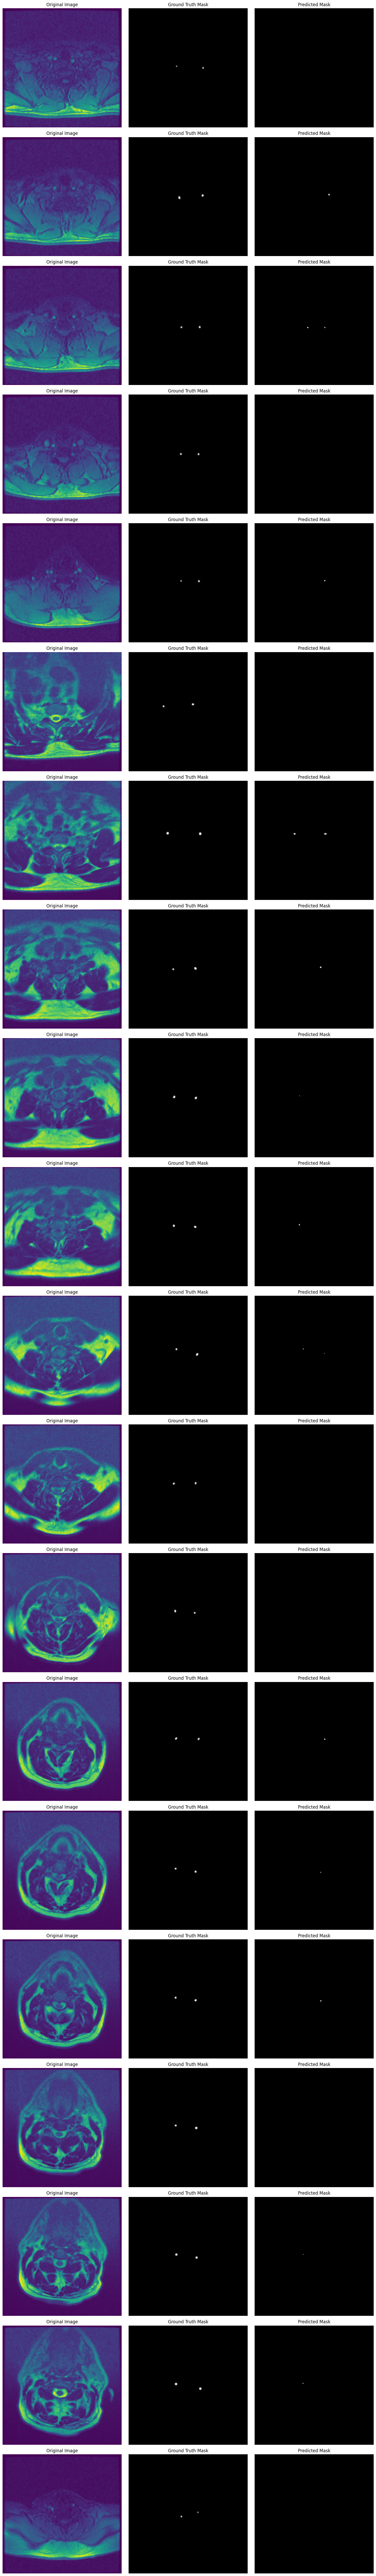

In [12]:
import matplotlib.pyplot as plt

def visualize_results(model, dataset, device, num_images=20):
    model.eval()
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    for i in range(num_images):
        image, mask = dataset[i]
        image_tensor = image.unsqueeze(0).to(device)
        mask = mask.numpy()

        with torch.no_grad():
            pred = model(image_tensor)["out"]
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_binary = (pred > 0.5).astype(np.uint8)

        axes[i, 0].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_binary, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_results(segmentation_model.model, dataset, device)